In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import os

DATA_PATH = "../../data/titanic/"
THRESH = 0.5
ROUNDS = 200

## Load the data

In [104]:
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"), delimiter=",", header=0, index_col=0)
test_x = pd.read_csv(os.path.join(DATA_PATH, "test.csv"), delimiter=",", header=0, index_col=0)
y_test = pd.read_csv(os.path.join(DATA_PATH, "gender_submission.csv"), delimiter=",", header=0, index_col=0)

### Prepare inputs

In [105]:
def encode_sex(df: pd.DataFrame) -> pd.DataFrame:
    """female=1, male=0"""
    df_c = df.copy()
    df_c["Sex"] = df_c["Sex"].apply(lambda x: 1 if x == "female" else 0).astype(np.uint8)
    return df_c

def encode_embarked(df: pd.DataFrame) -> pd.DataFrame:
    """S=0, C=1, Q=2"""
    df_c = df.copy()
    df_c["Embarked"] = df_c["Embarked"].apply(lambda x: 0 if x == "S" else 1 if x == "C" else 0).astype(np.uint8)
    return df_c

# Encode the categorical data
train_encoded = encode_sex(train)
test_x_encoded = encode_sex(test_x)
train_encoded = encode_embarked(train_encoded)
test_x_encoded = encode_embarked(test_x_encoded)

# Drop not used cols
train_encoded = train_encoded.drop(["Name", "Cabin", "Ticket"], axis=1)
X_test = test_x_encoded.drop(["Name", "Cabin", "Ticket"], axis=1)
X = train_encoded.drop(["Survived"], axis=1)
y = train_encoded["Survived"]

# Split data
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=1234)

# Create dmatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_eval, label=y_eval)
dtest = xgb.DMatrix(X_test, label=y_test)

### XGBoost

In [119]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.05,
    'eval_metric': ['error','logloss']
}

# Cross-Validation
cv_results = xgb.cv(params, dtrain, num_boost_round=ROUNDS, nfold=5, early_stopping_rounds=10, seed=42)

# Final Model
final_model = xgb.train(params, dtrain, num_boost_round=cv_results.shape[0])

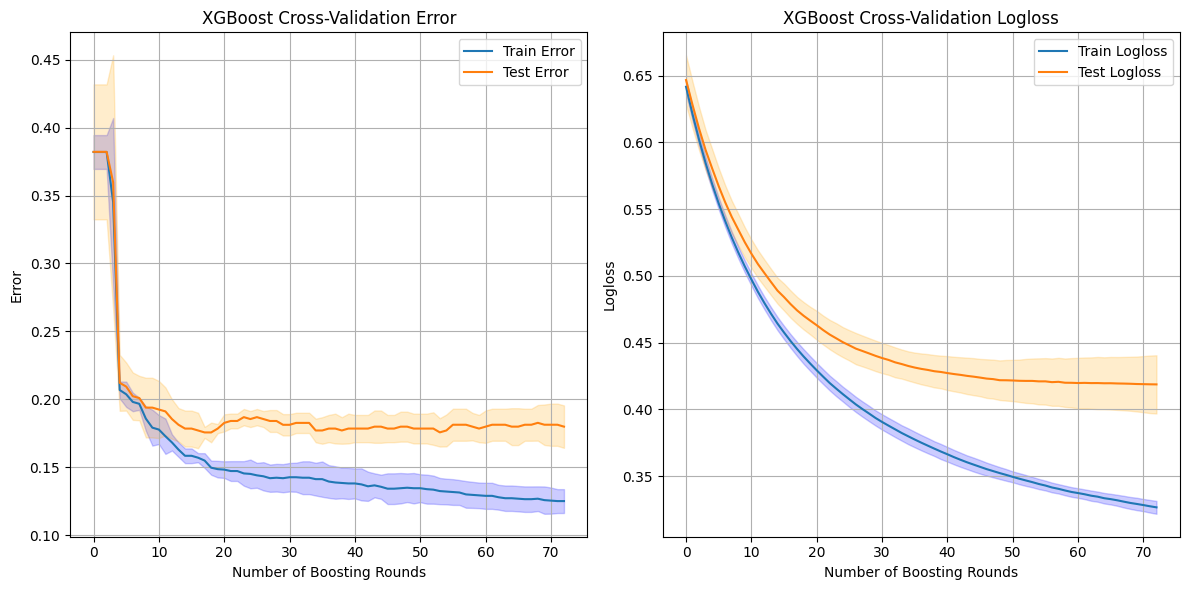

In [120]:
# Plot the results
plt.figure(figsize=(12, 6))

# Subplot for Error
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(cv_results['train-error-mean'], label='Train Error')
plt.plot(cv_results['test-error-mean'], label='Test Error')
plt.fill_between(range(len(cv_results)),
                 cv_results['train-error-mean'] - cv_results['train-error-std'],
                 cv_results['train-error-mean'] + cv_results['train-error-std'],
                 alpha=0.2, color='blue')
plt.fill_between(range(len(cv_results)),
                 cv_results['test-error-mean'] - cv_results['test-error-std'],
                 cv_results['test-error-mean'] + cv_results['test-error-std'],
                 alpha=0.2, color='orange')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('XGBoost Cross-Validation Error')
plt.legend()

# Subplot for Logloss
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(cv_results['train-logloss-mean'], label='Train Logloss')
plt.plot(cv_results['test-logloss-mean'], label='Test Logloss')
plt.fill_between(range(len(cv_results)),
                 cv_results['train-logloss-mean'] - cv_results['train-logloss-std'],
                 cv_results['train-logloss-mean'] + cv_results['train-logloss-std'],
                 alpha=0.2, color='blue')
plt.fill_between(range(len(cv_results)),
                 cv_results['test-logloss-mean'] - cv_results['test-logloss-std'],
                 cv_results['test-logloss-mean'] + cv_results['test-logloss-std'],
                 alpha=0.2, color='orange')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Logloss')
plt.title('XGBoost Cross-Validation Logloss')
plt.legend()

plt.tight_layout()
plt.show()


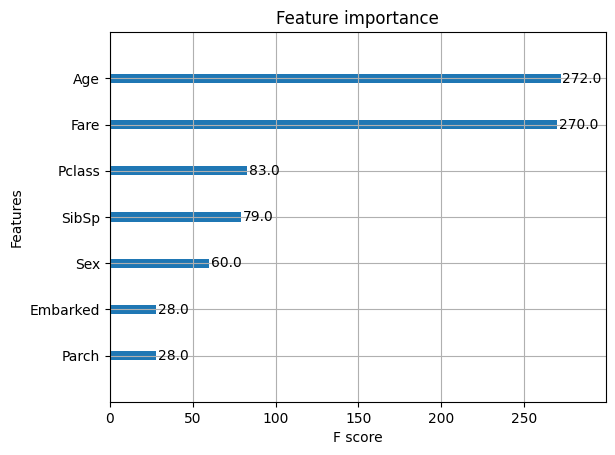

In [121]:
# Feature importance
xgb.plot_importance(final_model)
plt.show()

### Apply on test

In [123]:
submission = final_model.predict(dtest)
submission = (submission > THRESH).astype(int)
y_test["Survived"] = submission
y_test.to_csv(os.path.join(DATA_PATH, "my_submission.csv"), index=True, sep=",", header=1)